In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [8]:
#Imports

#Import linear algebra and data manipulation
import numpy as np
import pandas as pd

#Import plotting packages
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#Import machine learning
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost

from sklearn.model_selection import train_test_split #split
from sklearn.metrics import r2_score, mean_squared_error #metrics

In [9]:
df_listings = pd.read_csv("listings.csv")
df_calendar = pd.read_csv("calendar.csv")
df_reviews = pd.read_csv("reviews.csv")



**Question: What are the busiest times of the year to visit Seattle? By how much do prices spike?**
The most important problem I faced when planning for a trip is to keep it within a budget. Airbnb serves an economical option to frugal travllers across the globe. In this use case, I would like to project the busiest time of the year with a correlation to the price trend to find an optimal price for my budget.

**Approach**:
First of all, I chose Seattle dataset, and it will take me the following steps to come into conclusions about factors, affecting reservation prices:

1. The first look at the data:
    * what information we have?
    * what information is missing?
    * discover general facts: time period, total number of listings in the dataset,
2. Initial data preparation:
    * remove the irrelevant information;
    * reformat the information and imputing missing values;
3. High level analysis:
    * find out high level trends and correlations;
4. Use machine learning for further analysis.





**High level definition of the data files received from airbnb**

* listings.csv - summary information on listing in Seattle such as: location, host information, cleaning and guest fees, amenities etc.
* calendar.csv - calendar data for the listings: availability dates, price for each date.
* reviews.csv - summary review data for the listings. This dataset won't be used in further analysis.

**What information we have?**

In [10]:
#find number of listings and number of hosts
listings_number=df_listings['id'].count()
hosts= len(df_listings['host_id'].unique())
print(f'listings.csv dataset contains information on {listings_number} listings provided by {hosts} hosts.')

listings.csv dataset contains information on 3818 listings provided by 2751 hosts.


**What information is missing?**

<Axes: title={'center': 'Missing values per column, %'}>

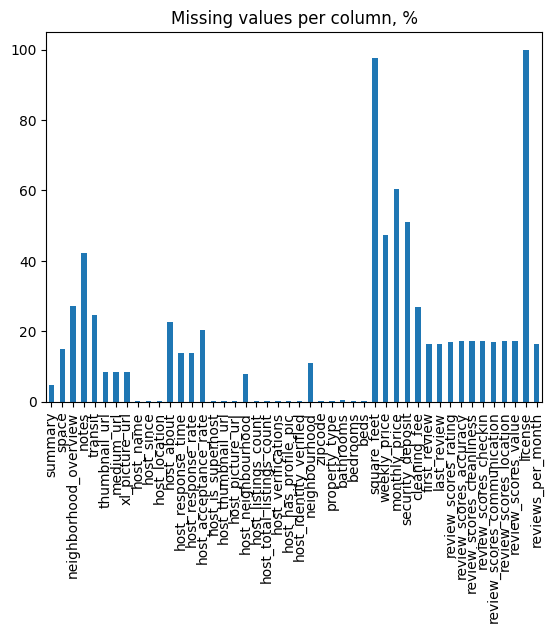

In [11]:
#find percentage of missing values for each column
listings_missing_df = df_listings.isnull().mean()*100

#filter out only columns, which have missing values
listings_columns_with_nan = listings_missing_df[listings_missing_df > 0]

#plot the results
listings_columns_with_nan.plot.bar(title='Missing values per column, %')

**Discover general facts**

As we see from the above graph,few columns like the license,square feet etc has the highest number of missing values.Also 40% of the data in the monthly price, monthly price, security deposit etc are missing. To avoid overfitting we must avoid the missing values from the irrelevant columns



**Stats about the calendar dataset**

In [12]:
df_calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


*Note: Price column has both \$ character and NaN values*

In [13]:
#find number of rows in dataset
rows_num = df_calendar.shape[0]

#find first and last date of the calendar
min_date = df_calendar['date'].min()
max_date = df_calendar['date'].max()

print(f'calendar.csv dataset contains {rows_num} rows.')
print(f'The first date of observation is {min_date} and the last date is {max_date}.')

calendar.csv dataset contains 1393570 rows.
The first date of observation is 2016-01-04 and the last date is 2017-01-02.


**Calendar data set missing value stats**

<Axes: title={'center': 'Missing values per column, %'}>

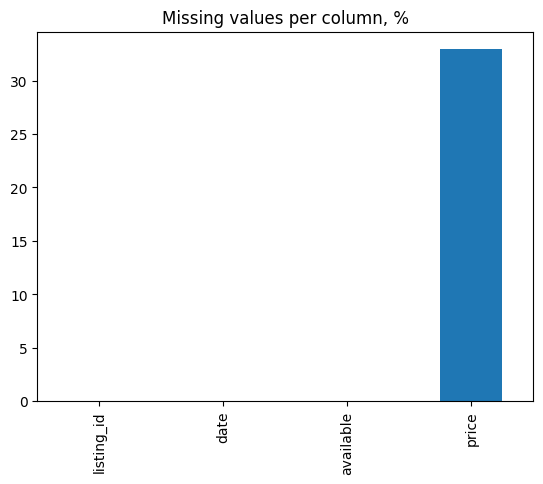

In [14]:
#find percentage of missing values for each column
calendar_missing_df = df_calendar.isnull().mean()*100
calendar_missing_df.plot.bar(title='Missing values per column, %')

From the outset it appears that there is a correlation to the missing price values with the available status of the listing

As we see on digram, there are only 32% percent of missing values for price column for dates, when the listing was unavailable.

**Cleansing the Data**

Before trying to get the first outcomes, the data should be pre-processed:

* Datasets should be merged into one using the listing identifier;
* Irrelevant columns and columns, which contain missing data should be removed from the analysis;
* Dates and prices should be converted from text into numbers.

In [15]:
#merge datasets
df_listings = df_listings.rename(index=str, columns={"id": "listing_id"})
df = pd.merge(df_calendar, df_listings, on = 'listing_id')

df.head()

,listing_id,date,available,price_x,listing_url,scrape_id,last_scraped,name,summary,space,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,241032,2016-01-04,t,$85.00,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
1,241032,2016-01-05,t,$85.00,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
2,241032,2016-01-06,f,NaN,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
3,241032,2016-01-07,f,NaN,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07
4,241032,2016-01-08,f,NaN,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,...,10.0,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07


In [16]:
 #drop the irrelevant columns
columns_to_drop = ['available', 'host_id','host_location','host_acceptance_rate','host_neighbourhood',
               'host_total_listings_count', 'weekly_price', 'monthly_price',
               'security_deposit', 'cleaning_fee', 'calendar_updated',
               'listing_url','last_scraped' ,'scrape_id', 'name', 'summary', 'space', 'description',
               'experiences_offered', 'street', 'neighbourhood', 'neighbourhood_cleansed', 'zipcode',
               'neighborhood_overview', 'notes', 'transit', 'thumbnail_url', 'medium_url', 'picture_url',
               'xl_picture_url', 'host_url', 'host_name', 'host_about', 'host_thumbnail_url', 'host_picture_url',
               'city', 'state', 'market', 'smart_location', 'country_code', 'country', 'latitude', 'longitude',
               'is_location_exact', 'square_feet', 'has_availability', 'availability_30',
               'availability_60', 'availability_90', 'availability_365', 'calendar_last_scraped',
              'first_review', 'last_review', 'requires_license', 'license', 'jurisdiction_names', 'price_y',
              'reviews_per_month']
df = df.drop(columns = columns_to_drop)

def get_val_from_list(row, column_name, value):
    ''' Fill in dummy column for values '''
    val = 0.0
    try:
        vals = row[column_name].replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(',')
        if value in vals:
            val = 1.0
    except:
        val = 0.0
    return val
def split_list_into_columns(df, column_name, max_dummies_num = 10):
    ''' Split values in columns, which contain lists (for example, amenities) '''
    
    # get dictionary of unique values in lists across dataset rows
    values_dict = {}

    for unique_value in df[column_name].unique(): 
        for value in unique_value.replace('[', '').replace("'", '').replace("]", '').replace('"', '').replace('{', '').replace('}', '').split(','):
            if value in values_dict:
                values_dict[value] = values_dict[value] + 1
            else:
                values_dict[value] = 0
                
    values_sorted = sorted(values_dict.items(), key=lambda kv: kv[1], reverse = True)
      
    # split into columns
    for value in values_sorted[: max_dummies_num]:
        df[column_name + '_' + value[0]] = df.apply(lambda row: get_val_from_list(row, column_name, value[0]),axis=1)
        
    return

In [17]:
#convert date from the calendar into month and drop the date colum
df['month'] = pd.to_datetime(df['date']).dt.month
df['year'] = pd.to_datetime(df['date']).dt.year
df = df.drop(columns = ['date'])

In [18]:
#remove rows where price_x == nan, because price will be used as response column
df = df.dropna(subset=['price_x'])
#convert price to number and drop the price_x column
df['price'] = df['price_x'].replace('[\$,]', '', regex=True).astype(float)

df = df.drop(columns = ['price_x'])
df.head()

,listing_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_listings_count,host_verifications,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,...,review_scores_location,review_scores_value,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,month,year,price
0,241032,2011-08-11,within a few hours,96%,f,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,...,9.0,10.0,f,moderate,f,f,2,1,2016,85.0
1,241032,2011-08-11,within a few hours,96%,f,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,...,9.0,10.0,f,moderate,f,f,2,1,2016,85.0
9,241032,2011-08-11,within a few hours,96%,f,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,...,9.0,10.0,f,moderate,f,f,2,1,2016,85.0
10,241032,2011-08-11,within a few hours,96%,f,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,...,9.0,10.0,f,moderate,f,f,2,1,2016,85.0
14,241032,2011-08-11,within a few hours,96%,f,3.0,"['email', 'phone', 'reviews', 'kba']",t,t,Queen Anne,...,9.0,10.0,f,moderate,f,f,2,1,2016,85.0


In [19]:
#convert host_since date into number and fill in missing values, drop the original column
df['host_since_year'] = pd.to_datetime(df['host_since']).dt.year
df.loc[:, 'host_since_year'] = df['host_since_year'].fillna(df['host_since_year'].mean())
df['host_since_year'] = df['host_since_year'].astype(int)
#df['host_since_year'].fillna(df['host_since_year'].mean(), inplace = True)
#df = df.drop(columns = ['host_since'])
#convert host_response_rate into number and fill in missing values, drop the original column
df['host_response_rate_num'] = df['host_response_rate'].astype(str)
df['host_response_rate_num'] = df['host_response_rate_num'].str.replace("%", "").astype("float")
df['host_response_rate_num'].fillna(df['host_response_rate_num'].mean(), inplace = True)

df['host_response_rate_buckets'] = pd.qcut(df['host_response_rate_num'], 5, labels=False, duplicates = 'drop')

df = df.drop(columns = ['host_response_rate', 'host_response_rate_num'])

/tmp/ipykernel_432/2216968528.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['host_response_rate_num'].fillna(df['host_response_rate_num'].mean(), inplace = True)


In [20]:
#split host_verifications into dummy columns and drop the original column
# Fill NaN values with an empty string
df['host_verifications'] = df['host_verifications'].fillna('')

# Split host_verifications into dummy columns and drop the original column
split_list_into_columns(df, 'host_verifications')
df = df.drop(columns = ['host_verifications'])


In [24]:
df.head()


,listing_id,host_since,host_response_time,host_is_superhost,host_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood_group_cleansed,property_type,room_type,...,host_verifications_email,host_verifications_ phone,host_verifications_ reviews,host_verifications_ facebook,host_verifications_ jumio,host_verifications_ kba,host_verifications_ linkedin,host_verifications_ google,host_verifications_ manual_offline,host_verifications_phone
0,241032,2011-08-11,within a few hours,f,3.0,t,t,Queen Anne,Apartment,Entire home/apt,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,241032,2011-08-11,within a few hours,f,3.0,t,t,Queen Anne,Apartment,Entire home/apt,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
9,241032,2011-08-11,within a few hours,f,3.0,t,t,Queen Anne,Apartment,Entire home/apt,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
10,241032,2011-08-11,within a few hours,f,3.0,t,t,Queen Anne,Apartment,Entire home/apt,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14,241032,2011-08-11,within a few hours,f,3.0,t,t,Queen Anne,Apartment,Entire home/apt,...,1.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


**Replaace categorical variables with the mode of the column**
Since the bathrooms and bed/bedrooms data is categorical and can impact the price we are filling the missing values with the mode of the column

In [23]:
 #fill in missing values for bathrooms, bedrooms and beds with mode
df['bathrooms'] = df['bathrooms'].fillna(df['bathrooms'].mode()[0])
df['bedrooms'] = df['bedrooms'].fillna(df['bedrooms'].mode()[0])
df['beds'] = df['beds'].fillna(df['beds'].mode()[0])

In [27]:
#turn extra people fee into binary column (1 - if fee for extra people is charged, 0 - otherwise)
if 'extra_people_fee' in df.columns:
    # Convert 'extra_people_fee' column to binary
    df['extra_people_fee'] = df['extra_people_fee'].apply(lambda x: 1 if x > 0 else 0)
df = df.drop(columns = ['extra_people'])

In [28]:
#df.describe()

#split amenities into dummy columns and drop the original column
split_list_into_columns(df, 'amenities')
df = df.drop(columns = ['amenities'])





KeyError: 'amenities'

In [30]:
#fill missing values for review scores columns
review_scores_columns = ['review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness',
                        'review_scores_checkin', 'review_scores_communication', 'review_scores_location',
                    'review_scores_value']
for column in review_scores_columns:
    df[column] = df[column].fillna(df[column].mean())

In [ ]:
if 'extra_people_fee' in df.columns:
    # Convert 'extra_people_fee' column to binary
    df['extra_people_fee'] = df['extra_people_fee'].apply(lambda x: 1 if x > 0 else 0)

**High Level Analysis**

Once the data sets are clean , we can take  a look at the basic statistics like central tendency and deviations. Let's start with the pricing data

In [31]:
#find minimum, maximum and average price for listing
min_price = df['price'].min()
max_price = df['price'].max()
mean_price = df['price'].mean()

print(f'Minimum price per listing is ${min_price}.')
print(f'Maximum price per listing is ${max_price}' )
print(f'Average price per listing is ${mean_price}.')

Minimum price per listing is 10.0$.
Maximum price per listing is 1650.0$
Average price per listing is 137.94485855103355$.
